In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

2025-03-21 13:21:12.884111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742559672.936046   13338 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742559672.951075   13338 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742559673.059914   13338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742559673.059931   13338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742559673.059932   13338 computation_placer.cc:177] computation placer alr

In [3]:
from scipy.integrate import odeint
import numpy as np
from numpy import sin, copy, zeros, float32

In [4]:
from matplotlib import pyplot

In [5]:
import sys
import os
from contextlib import redirect_stdout

In [ ]:
class mass_spring_damper_model:
    def __init__(self, m, k, b, x_0):
        """Inits pendulum constants and initial state

        # Arguments
            m: Mass
            k: Spring coeff
            b: Friction coeff
            x_0: Initial state
        """

        self.m = m
        self.k = k
        self.b = b
        self.x_0 = x_0



    def ode(self, x, t, u):
        """Dynamic equations of pendulum

        # Arguments
            x: [position of mass, velocity of mass]
            t: Time steps for ode solving
            u: External force applied to the mass

        # Returns
            Derivative of internal states
        """

        # ODE of mass-spring-damper model
        pos, acc = x[0], x[1]
        u = u[0]
        dxdt = [float(acc), float(-(self.b/self.m)*acc - (self.k/self.m)*pos + (1/self.m)*u)]

        return dxdt



    def update(self, u):
        """Interface function for pendulum model

        # Arguments
            u: External force applied to the mass

        # Returns
            Position of mass
        """
        # Solving ODE with scipy library
        x = odeint(self.ode, self.x_0, [0,0.1], args=(u,))

        self.x_0 = x[1]

        return x[1,0]

In [7]:
class lstm_model:
    def __init__(self, model_shape, num_lookback, num_u, num_y):
        """Inits lstm model parameters

        # Arguments
            model_shape: List of cell number for each layer
            num_lookback: Number of lookback
            num_u: Number of inputs
            num_y: Number of predictions
        """
        # Input features of LSTM model
        self.x = zeros((1,num_lookback,num_u+num_y))

        # Creates LSTM model
        num_x = num_u + num_y
        num_layers = len(model_shape)

        self.model = Sequential()

        if np.isclose(num_layers, 1):
            num_cells = model_shape[0]
            self.model.add(LSTM(num_cells, input_shape=(num_lookback,num_x)))

        else:
            num_cells = model_shape[0]
            self.model.add(LSTM(num_cells, input_shape=(num_lookback,num_x),
                                return_sequences=True))

            for num_cells in model_shape[1:-1]:
                self.model.add(LSTM(num_cells, return_sequences=True))

            num_cells = model_shape[-1]
            self.model.add(LSTM(num_cells))

        self.model.add(Dense(num_y))
        self.model.compile(loss='mean_squared_error', optimizer='adam')

        self.model.summary()


    def _reshape(self, x_data, y_data):
        """Reshapes training data for LSTM

        # Arguments
            x_data: Features data
            y_data: Prediction data

        # Returns
            Reshaped x_data and y_data
        """

        num_lookback, num_x = self.model.input_shape[1:]
        num_y = self.model.output_shape[-1]

        # Create new x_data by stacking input features and predictions together
        x_data_new = np.array([
            np.concatenate([
                x_data[:, i:i + num_lookback, :],
                y_data[:, i:i + num_lookback, :]
            ], axis=-1)
            for i in range(x_data.shape[1] - num_lookback)  # <- num_lookback is now an int
        ])

        # Transpose to match expected shape
        x_data_new = x_data_new.transpose(1, 0, 2, 3)

        # Create new y_data
        y_data_new = y_data[:, num_lookback:]

        return x_data_new, y_data_new



    def fit(self, x_data, y_data, num_epochs, validation_split=0.2):
        """Trains LSTM model

        # Arguments
            x_data: Features data
            y_data: Prediction data
            num_epochs: Number of epochs
            validation_split: Number of validation sample / Number of training sample
        """

        x_data = copy(x_data)
        y_data = copy(y_data)

        # Reshapes data for LSTM model
        x_data, y_data = self._reshape(x_data, y_data)

        _, num_lookback, num_x = self.model.input_shape
        _, num_y = self.model.output_shape

        x_data = x_data.reshape(-1, num_lookback, num_x)
        y_data = y_data.reshape(-1)


        # Trains LSTM model
        checkpoint = ModelCheckpoint('temp_model.keras', save_best_only=True)
        self.model.fit(x_data, y_data, epochs=num_epochs,
                   verbose=1, validation_split=validation_split,
                   callbacks=[checkpoint,])

        self.lstm_model = load_model('temp_model.keras')




    def update(self, u):
        """Interface function for LSTM model

        # Arguments
            u: Input value

        # Returns
            Prediction of LSTM model
        """
        # Fills input
        self.x[0,:-1,0] = self.x[0,1:,0]
        self.x[0,-1,0] = u

        # Predicts output
        # Suppress output during prediction
        with open(os.devnull, 'w') as fnull:
            with redirect_stdout(fnull):
                y_pred = self.model.predict(self.x)

        # Fills output
        self.x[0,:-1,1] = self.x[0,1:,1]
        self.x[0,-1,1] = y_pred

        return y_pred[0]

In [8]:
from numpy import cumsum, zeros, random, float32

In [9]:
num_samples = 256 #1024
num_timesteps = 64 #64
split_ratio = 0.2

In [10]:
m = 1
k = 8
b = 0.8
x_0 = [0, 0]

In [11]:
model_shape= [8, 4]
num_lookback = 4
num_epochs = 32

In [12]:
x_data = cumsum(random.rand(num_samples,num_timesteps,1)-0.5, axis=1)
y_data = zeros(x_data.shape, dtype=float32)

In [13]:
for sample_index, input_signal in enumerate(x_data):
    # Creates dynamic pendulum model
    msd = mass_spring_damper_model(m, k, b, x_0)

    for time_index, u in enumerate(input_signal):
        y_data[sample_index, time_index] = msd.update(u)

In [14]:
# Split training and test data
x_test = x_data[:int(num_samples*split_ratio),]
y_test = y_data[:int(num_samples*split_ratio):,]
x_train = x_data[int(num_samples*split_ratio):,]
y_train = y_data[int(num_samples*split_ratio):,]

In [15]:
print('x_train.shape..:', x_train.shape)
print('y_train.shape..:', y_train.shape)

x_train.shape..: (205, 64, 1)
y_train.shape..: (205, 64, 1)


/tmp/ipykernel_13338/3276436713.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  pyplot.legend(loc='best')


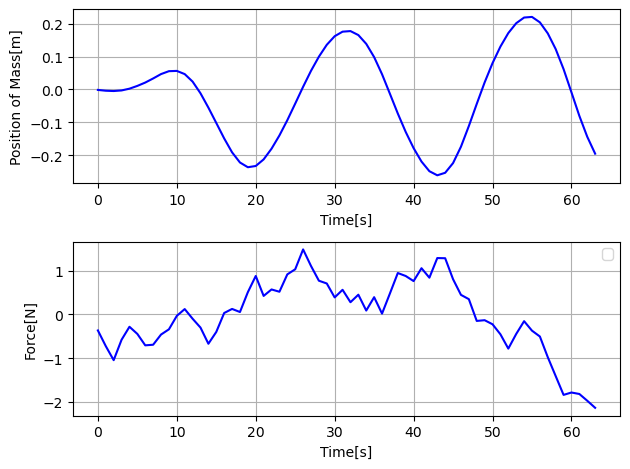

In [16]:
pyplot.subplot(2,1,1)
pyplot.plot(y_data[0,], 'b')
pyplot.xlabel('Time[s]')
pyplot.ylabel('Position of Mass[m]')
pyplot.grid()

# Plot one input signal
pyplot.subplot(2,1,2)
pyplot.plot(x_train[0,], 'b')
pyplot.xlabel('Time[s]')
pyplot.ylabel('Force[N]')
pyplot.legend(loc='best')
pyplot.grid()

pyplot.tight_layout()
pyplot.show()

In [17]:
num_u = x_train.shape[2]
num_y = y_train.shape[2]

In [18]:
print('num_u..:', num_u)
print('num_y..:', num_y)

num_u..: 1
num_y..: 1


In [19]:
lstm = lstm_model(model_shape, num_lookback, num_u, num_y)
lstm.fit(x_train, y_train, num_epochs)

I0000 00:00:1742559693.128939   13338 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5814 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Super with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/sam/miniconda3/envs/pandora/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4, 8)           │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4)              │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 565 (2.21 KB)

 Trainable params: 565 (2.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


I0000 00:00:1742559695.439718   14379 cuda_dnn.cc:529] Loaded cuDNN version 90300


308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0102 - val_loss: 0.0032
Epoch 2/32
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 3/32
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 4/32
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 5/32
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/32
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 7/32
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 8/32
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 9.8603e-04
Epoch 9/32
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.3282e-04 - val_loss: 5.0561e-04
Epoch 10/32
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.6123e-04 - val_loss: 2.4432e-04
Epoch 11/32
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5305e-04 - val_loss: 1.2438e-04
Epoch 12/32
308/308 ━━━━━━━━━━━━━━━

In [20]:
y_pred = zeros(y_test.shape)
for sample_index in range(x_test.shape[0]):
    for time_index in range(x_test.shape[1]):
        y_pred[sample_index, time_index] = lstm.update(x_test[sample_index,time_index,0])

/tmp/ipykernel_13338/1337792615.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.x[0,-1,1] = y_pred


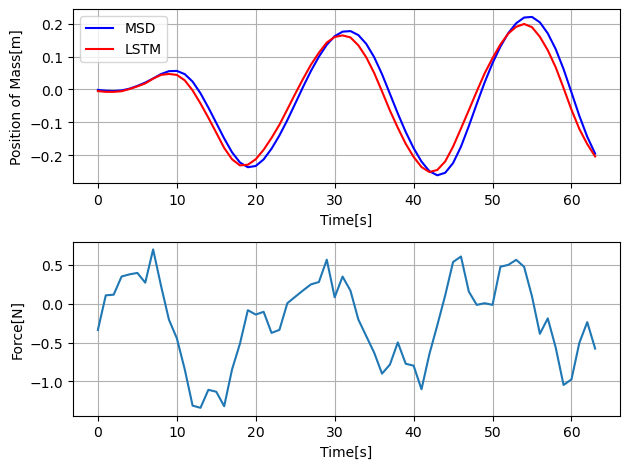

In [21]:
pyplot.subplot(2,1,1)
pyplot.plot(y_test[0,:,0], 'b', label='MSD')
pyplot.plot(y_pred[0,:,0], 'r', label='LSTM')
pyplot.xlabel('Time[s]')
pyplot.ylabel('Position of Mass[m]')
pyplot.legend(loc='best')
pyplot.grid()

# Plots requested torque by PID controller
pyplot.subplot(2,1,2)
pyplot.plot(x_test[0,:,0])
pyplot.xlabel('Time[s]')
pyplot.ylabel('Force[N]')
pyplot.grid()

pyplot.tight_layout()
pyplot.show()